In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest/movies.csv', encoding='latin-1')
print (movies.shape)
movies.head()

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
user_movie_matrix = train_set.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", user_movie_matrix.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/user_movie_matrix.values.size*100))
user_movie_matrix.head(10)

UM Matrix value size 5346650
ratings value size 403344
Sparisity: 1.89%


movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193567,193571,193579,193581,193583,193585,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# similarity
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [8]:
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = user_movie_matrix.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in user_movie_matrix.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3 :
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [9]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = user_movie_matrix[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in user_movie_matrix.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId       sim
0     566  1.000000
1     418  0.666667
2     484  0.666667
3     489  0.666667
4     182  0.585786
   movieId  sim
0      233  1.0
1     2524  1.0
2     2940  1.0
3     3365  1.0
4     4902  1.0


In [11]:
def predictRating(id_num, nn=50, simFunc=distance_cosine, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if two or more are NaN
        neighbor_movie = user_movie_matrix.loc[neighbor_id].dropna(1, how = 'all', thresh = 2)
        # User id x DataFrame of movie id. However, if the NaN of the column is 2 or more, it is deleted.

        neighbor_dic = dict(neighbor)
        ret = [] 
        #['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = user_movie_matrix[neighbor_id].dropna(0, how = 'all', thresh = 2)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [12]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[4, 4.5],
 [28, 4.1250378890979125],
 [36, 2.5000126277140304],
 [50, 3.0],
 [51, 3.7498741504840916],
 [62, 4.0],
 [63, 4.666629299658893],
 [68, 3.0],
 [95, 3.4997407058194097],
 [101, 3.000424808912686],
 [105, 4.333156661633008],
 [111, 3.3332505510935277],
 [125, 4.166476434002275],
 [152, 4.0],
 [177, 3.4996851021473487],
 [182, 4.400002913616094],
 [184, 4.250011273782536],
 [187, 4.749789093458589],
 [199, 3.166655537593269],
 [210, 4.5],
 [221, 4.0],
 [226, 3.0000651271969625],
 [232, 3.499958147948216],
 [238, 3.499953384177859],
 [249, 3.8749994615522247],
 [256, 4.0],
 [274, 3.28555299302397],
 [288, 2.9997029133052764],
 [298, 2.0],
 [305, 3.9999951310064707],
 [313, 2.334070421378674],
 [318, 3.9999145188096246],
 [325, 3.0001930026222863],
 [330, 4.0],
 [332, 3.7500449050162272],
 [339, 4.249995630607826],
 [372, 2.9998984335890393],
 [380, 4.454410069006716],
 [385, 3.5002124044563425],
 [387, 3.583262087238235],
 [391, 4.0],
 [414, 3.7381181924393743],
 [422, 3.750083

In [13]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(train_set[train_set.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
0,5.0,Duck Soup (1933),Comedy|Musical|War,1256
98,5.0,Winnie the Pooh and the Blustery Day (1968),Animation|Children|Musical,1023
126,5.0,Alice in Wonderland (1951),Adventure|Animation|Children|Fantasy|Musical,1032
125,5.0,"Thin Red Line, The (1998)",Action|Drama|War,2427
123,5.0,Face/Off (1997),Action|Crime|Drama|Thriller,1573


In [14]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
187,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,5.0
290,1673,Boogie Nights (1997),Drama,5.0
234,1219,Psycho (1960),Crime|Horror,5.0
136,541,Blade Runner (1982),Action|Sci-Fi|Thriller,5.0
314,2067,Doctor Zhivago (1965),Drama|Romance|War,5.0
276,1391,Mars Attacks! (1996),Action|Comedy|Sci-Fi,5.0
226,1204,Lawrence of Arabia (1962),Adventure|Drama|War,5.0
192,951,His Girl Friday (1940),Comedy|Romance,5.0
252,1261,Evil Dead II (Dead by Dawn) (1987),Action|Comedy|Fantasy|Horror,5.0
326,2324,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War,5.0


In [15]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
17,187,4.749789
6,63,4.666629
0,4,4.500000
19,210,4.500000
37,380,4.454410
15,182,4.400003
10,105,4.333157
16,184,4.250011
35,339,4.249996
48,483,4.249563


In [16]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
15,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,5.000000
33,NaN,NaN,NaN,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,5.000000
35,NaN,NaN,NaN,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,5.000000
29,5.0,Billy Madison (1995),Comedy,216,Billy Madison (1995),Comedy,5.000000
36,NaN,NaN,NaN,17,Sense and Sensibility (1995),Drama|Romance,5.000000
34,NaN,NaN,NaN,1208,Apocalypse Now (1979),Action|Drama|War,5.000000
9,5.0,"Green Mile, The (1999)",Crime|Drama,3147,"Green Mile, The (1999)",Crime|Drama,5.000000
1,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.875179
37,NaN,NaN,NaN,5971,My Neighbor Totoro (Tonari no Totoro) (1988),Animation|Children|Drama|Fantasy,4.875017
17,5.0,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller,4.833390


In [17]:
eval_ratings = test_set

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [18]:
## all userId list 
users = user_movie_matrix.index.tolist()
## 10-person star rating
predicted_user = eval_prediction(users[:5], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 0.908137775051518 
MAE of user_cosine is 0.9200087469390631 
MAE of user_euclidean is 1.036113857489425 
RMSE of mean_rating is 1.147385229678113 
RMSE of user_cosine is 1.2251589975043806 
RMSE of user_euclidean is 1.3410681460189802 


In [19]:
users = user_movie_matrix.index.tolist()
predicted_item = eval_prediction(users[:5], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.7127100541734688 
Item-item MAE of item_cosine is 0.6217610925009485 
Item-item MAE of item_euclidean is 0.6502633639350575 
Item-item RMSE of mean_rating is 0.9605611414668107 
Item-item RMSE of item_cosine is 0.7617149710274561 
Item-item RMSE of item_euclidean is 0.8258902584415947 


In [20]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
541,5,380,2.0,847434748,3.475000,3.596635,3.525705
702,3,2424,0.5,1306464293,3.000000,3.070521,3.040435
873,4,1500,4.0,964622830,3.692308,2.000000,3.630459
1011,1,2502,5.0,964981278,4.280000,3.706596,4.109112
1133,5,349,3.0,847434832,3.518519,3.627989,3.642099
1911,1,223,3.0,964980985,3.916667,3.537045,3.873879
2676,2,48516,4.0,1445715064,4.136364,4.196845,4.305517
2705,4,357,3.0,964623306,3.425926,2.152646,3.006871
2824,5,594,5.0,847435238,3.857143,3.978401,4.246780
2937,2,46970,4.0,1445715013,3.500000,4.120721,3.625732


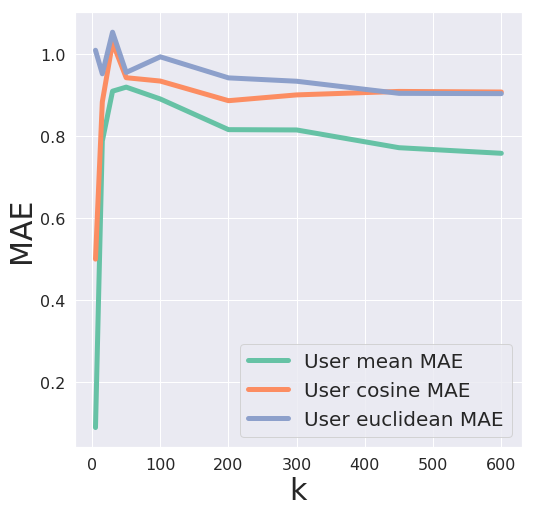

In [21]:
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []

for k in k_array:
    predicted_user = eval_prediction(users[:10], k, kind = 'user')

    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

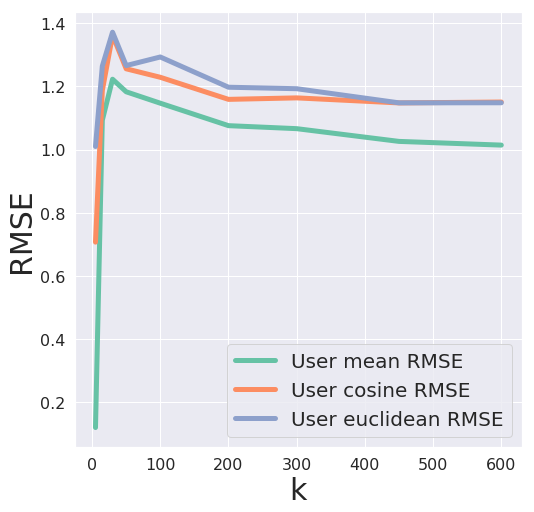

In [22]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

In [23]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[0.08900402103309624, 0.7881818349667611, 0.909949557929322, 0.9198697145973642, 0.89096695449584, 0.8161000072963362, 0.8153348219307871, 0.7720296418970343, 0.7583802586698429]
[0.12021453925528192, 1.0927833836864191, 1.2227590758757305, 1.18300190650169, 1.146872011084215, 1.075779499638909, 1.0662655751708858, 1.0259420690772032, 1.0142078852610124]
[0.5001000502845292, 0.8837566750883463, 1.0286063751022483, 0.9428732355157375, 0.9346923919474139, 0.886781033209657, 0.9009179662066651, 0.9093801246493051, 0.9079470476996742]
[0.7071067953429092, 1.187053649096526, 1.3622551758617205, 1.255745007809388, 1.2288949881050812, 1.1589921907324974, 1.1637037481302166, 1.1477556023978248, 1.1505930734757606]
[1.0098474314770094, 0.9524233467993715, 1.053982917029677, 0.9557672032982422, 0.9938489755664927, 0.9424676952641664, 0.9342356002956399, 0.904692856908546, 0.9040190582063777]
[1.0098954434828427, 1.264166910985005, 1.3716538914899148, 1.2659637158210741, 1.2931481004105223, 1.197

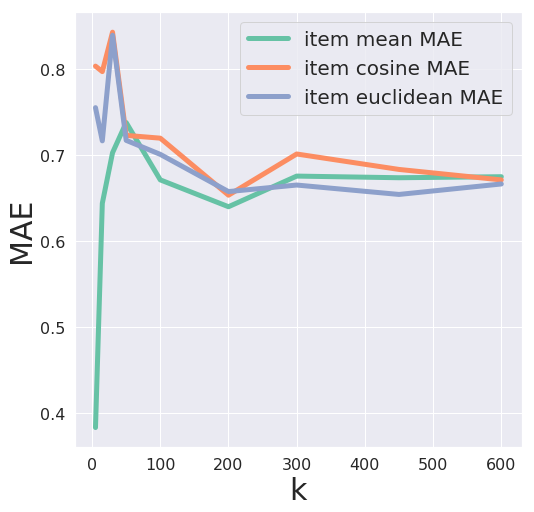

In [24]:
k_array = [5, 15, 30, 50, 100, 200, 300, 450, 600]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

for k in k_array:
    predicted_item = eval_prediction(users[:10], k, kind = 'item')

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

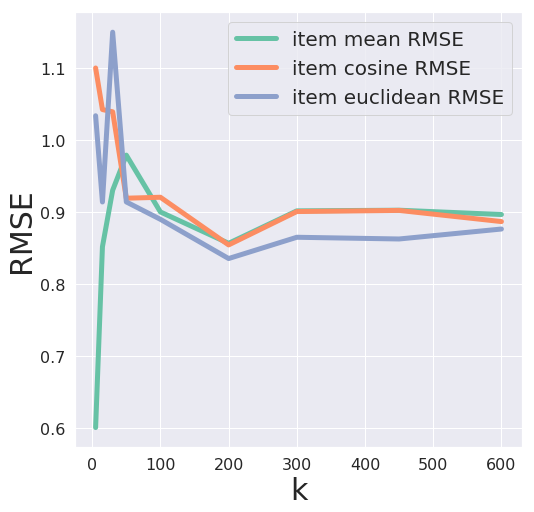

In [25]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

In [26]:
print(user_mean_MAE)
print(user_mean_RMSE)
print(user_cosine_MAE)
print(user_cosine_RMSE)
print(user_euc_MAE)
print(user_euc_RMSE)

[0.08900402103309624, 0.7881818349667611, 0.909949557929322, 0.9198697145973642, 0.89096695449584, 0.8161000072963362, 0.8153348219307871, 0.7720296418970343, 0.7583802586698429]
[0.12021453925528192, 1.0927833836864191, 1.2227590758757305, 1.18300190650169, 1.146872011084215, 1.075779499638909, 1.0662655751708858, 1.0259420690772032, 1.0142078852610124]
[0.5001000502845292, 0.8837566750883463, 1.0286063751022483, 0.9428732355157375, 0.9346923919474139, 0.886781033209657, 0.9009179662066651, 0.9093801246493051, 0.9079470476996742]
[0.7071067953429092, 1.187053649096526, 1.3622551758617205, 1.255745007809388, 1.2288949881050812, 1.1589921907324974, 1.1637037481302166, 1.1477556023978248, 1.1505930734757606]
[1.0098474314770094, 0.9524233467993715, 1.053982917029677, 0.9557672032982422, 0.9938489755664927, 0.9424676952641664, 0.9342356002956399, 0.904692856908546, 0.9040190582063777]
[1.0098954434828427, 1.264166910985005, 1.3716538914899148, 1.2659637158210741, 1.2931481004105223, 1.197